Linear Regression Model Between Stock Prices

The calculated correlation coefficient without the use of the linregress library is:  0.026551295701909918
The correlation coefficient between the monthly returns of FTSE100 and UK House prices:  0.026551295701909915
Std error from regression:  0.016193638095225817
t:  0.4668937880569303
degree of freedom is:  309
Calculated p value:  0.6409049000031651
p value from scipy:  0.6409049000031651


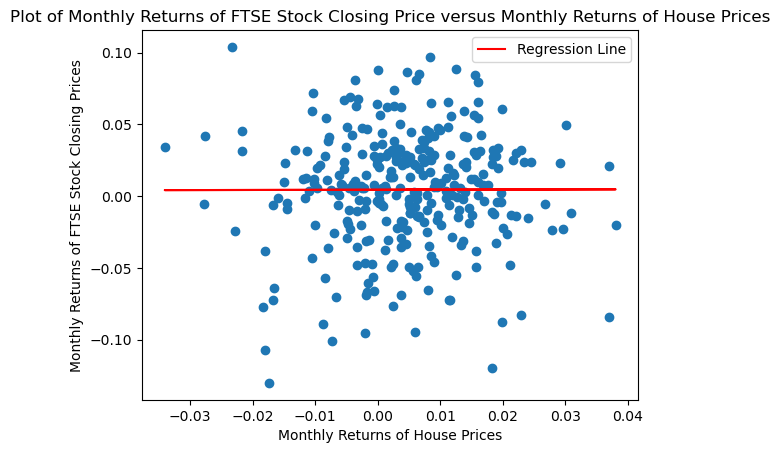

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats


# Data Importation and Cleanup
ftse_data = pd.read_csv("FTSE100.csv") # Loading of the FTSE100 index from Yahoo Finance 
ftse_data = ftse_data.iloc[::-1] # reversing the order of the data
ftse_data.index = np.arange(len(ftse_data)) # resetting the index of the data
ftse_data = ftse_data.set_index('Date') # Setting Date as the index

house_price = pd.read_excel("Monthly.xls") # Loading of the monthly UK house prices
column = list(house_price.columns) # extracting columns of house prices
column[0] = 'Date' # editing of the names of one of the columns
house_price.columns = column # fixing columns of house prices
house_price = house_price.set_index('Date') # Setting Date as the index

# Dependent varibale = FTSE100 index monthly returns
# Independent variable = House price monthly returns

# Generation of Monthly Returns of FTSE 100 and Monthly House Prices
def monthly_return(array):
    """
        Calculates the monthly return of an array
    """
    result = [] # list storing monthly returns
    for i in range(len(array)):
        if i == 0:
            result.append(np.nan) # dealing with the calculation of the first monthly return for January
        else:
            value = (array[i]/array[i-1])-1 # claculation of the monthly return
            result.append(value)
    return result

return_ftse = monthly_return(ftse_data['Adj Close']) # Monthly returns of FTSE 100 stock
ftse_data['Monthly Returns Adj Close'] = return_ftse # Monthly returns of FTSE_100

return_house = monthly_return(house_price['Average House Price']) # Monthly returns of house prices
house_price['Monthly Returns of Average House Prices'] = return_house # Monthly returns of house prices
house_price = house_price.loc[:'2016-12-01',:] # selection of house prices till 2016

# Linear Regression Model

ftse_ret = ftse_data['Monthly Returns Adj Close'] # choosing a column
ftse_ret = ftse_ret.loc['2/1/1991':] #getting rid of the nan values
house_ret = house_price['Monthly Returns of Average House Prices'] # choosing a column
house_ret = house_ret.loc['1991-02-01':] # getting rid of the nan values
gradient, yintercept, corr_coeff, pvalue, stderr = stats.linregress(ftse_ret, house_ret)

def regress_line(i_var):
    regress_line = gradient*i_var + yintercept
    return regress_line

regress_mod = list(map(regress_line, house_ret))

corr_coef = np.corrcoef(house_ret.to_numpy(), ftse_ret.to_numpy())[0][1] # The calculated correlation coefficient

print("The calculated correlation coefficient without the use of the linregress library is: ", corr_coef)
print("The correlation coefficient between the monthly returns of FTSE100 and UK House prices: ", corr_coeff)
print("Std error from regression: ", stderr)

# Graph Plot
plt.title("Plot of Monthly Returns of FTSE Stock Closing Price versus Monthly Returns of House Prices")
plt.xlabel("Monthly Returns of House Prices")
plt.ylabel("Monthly Returns of FTSE Stock Closing Prices")
plt.scatter(house_ret, ftse_ret)
plt.plot(house_ret, regress_mod, color='r', label='Regression Line')
plt.legend()

# Hypothesis test
# Ho: slope = 0 (The two data samples are not correlated)
# H1: slope ≠ 0 (The two data samples are correlated)

# We use a t test here
t = gradient/stderr # The manual uses wald's t test
degree_freedom = len(house_ret) - 2 # degree of freedom is n-2
p_value = stats.t.sf(abs(t), df=degree_freedom)*2 # scipy's linear_regress function uses a degree of freedom of n-2
print("t: ", t)
print("degree of freedom is: ", degree_freedom)
print("Calculated p value: ", p_value)
print("p value from scipy: ", pvalue)

# Since p is greater than 0.05, our null hypothesis cannot be rejected. The null hypothesis is true.
# This means our predicted values significantly deviate from our actual values
# No relationship exists between the two variables

Feature Selection: Backward Elimination

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

# Data Importation and Cleanup
college_data = pd.read_csv("College.csv") # Importation of college data
schools= list(college_data.iloc[:,0]) #Extraction of schools
college_data = college_data.iloc[:, [2,4,5,6,9,-1]] # extracts the needed columns
college_data.index = schools # Setting index as schools

correlation_var = college_data.corr() # calculates correlation between all the variables
correlation_grad = correlation_var.iloc[5,:-1].to_frame()
print(f"Correlation coefficients for graduation rate of all of the variables are: \n\n{correlation_grad}\n\n")

# Stepwise Regression Model
ind_varsList = list(college_data.columns) # list of independent variables
ind_varsList.remove('Grad.Rate') # removing the dependent variable

dep_var = college_data.loc[:,"Grad.Rate"] # data for dependent variable

def back_elim():
    ind_vars = college_data[ind_varsList] # extracts the data for all independent variables
    while True:
        reg_mod = sm.OLS(dep_var, ind_vars).fit() # fitting the data with OLS
        pvals = reg_mod.pvalues # extraction of p_values
        max = pvals.max() # Gets the maximum pvalue and its index
        idxmax = pvals.idxmax()
        if max > 0.05: # if the maximum p value exceed 0.05, get rid of it
            ind_vars = ind_vars.drop(idxmax, axis=1)
        elif max < 0.05: 
            # if the maximum value does not exceed 0.05, it means all p values are below 
            # 0.05; hence, you have to quit.
            break
    return list(ind_vars.columns)
            
chosen_vars = back_elim() # chosen variables from the stepwise regression model

X_train = college_data[chosen_vars] # independent training data
y_train = dep_var.to_numpy() # dependent training data
step_model = LinearRegression().fit(X_train, y_train) # Training stepwise linear regression model
ystep_pred = step_model.predict(X_train) # Prediction 

# BIC Regression
reg_bic = linear_model.LassoLarsIC(criterion='bic', normalize=False) # Selection of BIC Model using LassoLarsIC
ind_vars2 = college_data[ind_varsList] # extracts the data for all independent variables
regmod_bic = reg_bic.fit(ind_vars2, dep_var) # training the BIC model for variable selection

def bic_select(independent_vars):
    coeff_values = list(regmod_bic.coef_)
    index_elim = coeff_values.index(0) # index of variable to eliminate
    elim_var = regmod_bic.feature_names_in_[index_elim] # Taking the note of a variable with zero coefficient
    chosenBIC_varsdata = independent_vars.drop([elim_var], axis=1) # chosen variables from BIC
    return chosenBIC_varsdata

chosenBIC_varsdata = bic_select(ind_vars2) # getting the dataset of chosen BIC independent variables
chosenBIC_vars = list(chosenBIC_varsdata.columns) # Chosen Variables by BIC model

# Standard BIC Selected Model
bicmodel= reg_bic.fit(chosenBIC_varsdata, dep_var) # Creating a new BIC model based on chosen variables 
bicpred = bicmodel.predict(chosenBIC_varsdata) # Predictions based on BIC model

# Linear Model with all Variables
X_allvartrain = college_data.loc[:,:'Outstate'] # Selection of all the independent variables
allvar_regmod = LinearRegression().fit(X_allvartrain, y_train) # Train the linear model with all variables
ypred_allvar = allvar_regmod.predict(X_allvartrain) # Make predictions based on independent variables

# Accuracy of Stepwise
stepwise_accuracy = mean_absolute_percentage_error(y_train, ystep_pred)*100 # Stepwise accuracy computed via MAPE

# Accuracy of BIC Model
bic_accuracy = mean_absolute_percentage_error(y_train,bicpred)*100 # BIC accuracy computed via MAPE

# Accuracy of Linear Model with all Five Variables
allvar_accuracy = mean_absolute_percentage_error(y_train, ypred_allvar)*100 # Accuracy of linear model using MAPE

# Since the Linear model with all five variables is the most accurate model, I use it to predict 
# CMU's graduate rate.
cmu_gradRate = ypred_allvar[87] # predicted CMU Graduation Rate

print("Stepwise MAPE Error is: ", stepwise_accuracy,"%")
print("BIC model MAPE Error is: ", bic_accuracy, "%")
print("Linear model error using all five predictor variables is: ", allvar_accuracy, "%")
print("CMU predicted graduation rate with the most accurate model is: ", cmu_gradRate, "%")
print("Chosen Variables for Stepwise Regression Model: ",chosen_vars)
print("Chosen Variables for BIC Regression Model: ",chosenBIC_vars)

Correlation coefficients for graduation rate of all of the variables are: 

           Grad.Rate
Apps        0.146755
Enroll     -0.022341
Top10perc   0.494989
Top25perc   0.477281
Outstate    0.571290


Stepwise MAPE Error is:  19.20818940530324 %
BIC model MAPE Error is:  19.071379260776563 %
Linear model error using all five predictor variables is:  19.051288181781935 %
CMU predicted graduation rate with the most accurate model is:  89.20112305346859 %
Chosen Variables for Stepwise Regression Model:  ['Enroll', 'Top10perc', 'Top25perc', 'Outstate']
Chosen Variables for BIC Regression Model:  ['Apps', 'Enroll', 'Top25perc', 'Outstate']


Polynomial Regression

      All Road Users Killed  All Traffic (Billion Vehicle Miles)
Year                                                            
1950                   5012                            45.360097
1951                   5250                            49.523284
1952                   4706                            52.027410
1953                   5090                            53.208015
1954                   5010                            54.997564
...                     ...                                  ...
2017                   1793                           335.968054
2018                   1784                           337.732649
2019                   1752                           342.224363
2020                   1460                           271.192688
2021                   1558                           301.757072

[72 rows x 2 columns]


t statistic is:  -8.852342241908941
degree of freedom is:  59
Calculated p value is:  2.0147859525577424e-12
Gradient of linear re

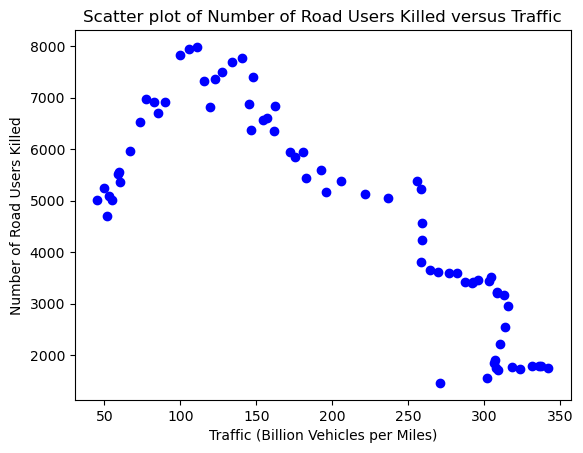

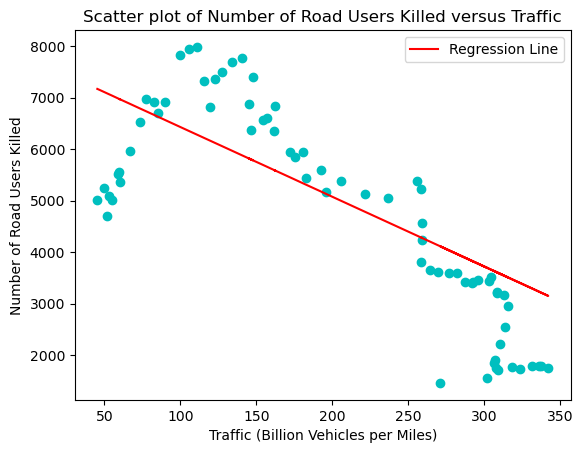

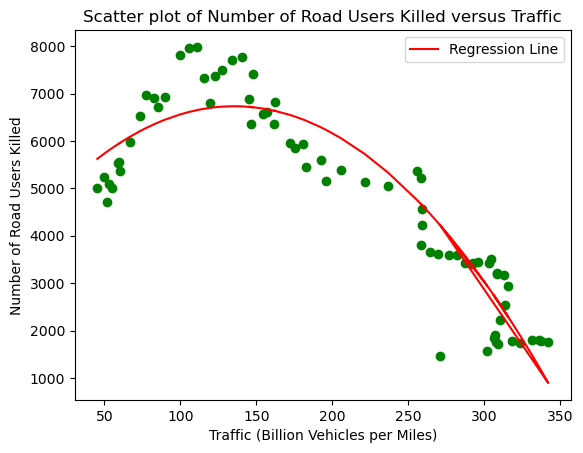

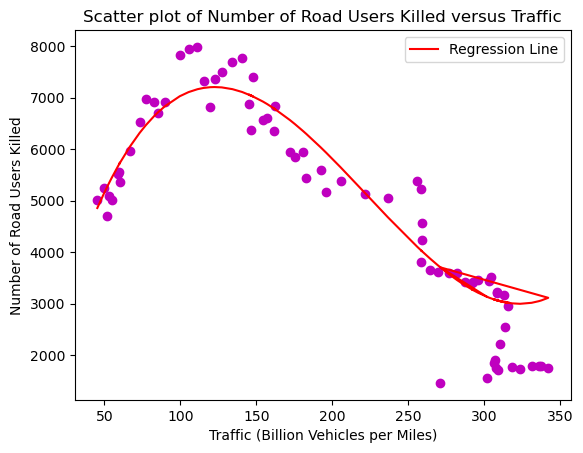

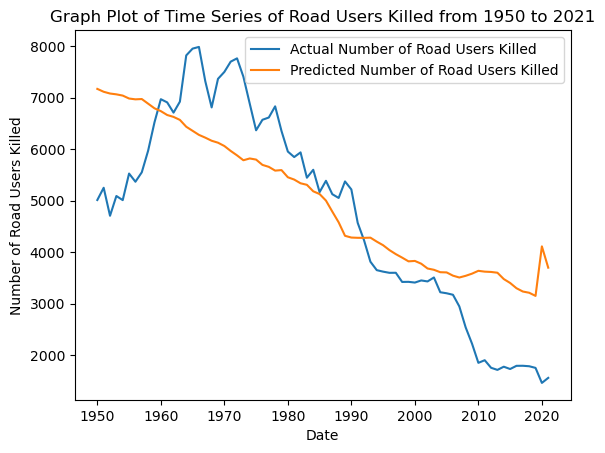

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

# Data Importation
ras_data = pd.read_excel("RAS0101.xlsx", sheet_name ="Casualties", skiprows=30, usecols="A,G,M") # Road accident statistics
ras_data.columns = ['Year', 'All Road Users Killed', 'All Traffic (Billion Vehicle Miles)']
ras_data = ras_data.set_index('Year')

x_var = ras_data['All Traffic (Billion Vehicle Miles)']
y_var = ras_data['All Road Users Killed']

# Training Set and Test Set Generation
X_train = x_var.loc[1950:2010]
X_test = x_var.loc[2011:]

y_train = y_var.loc[1950:2010]
y_test = y_var.loc[2011:]

# Linear Regression Model
gradient, yintercept, corr_coeff, pvalue, stderr = stats.linregress(X_train, y_train)

# Hypothesis Testing
# Ho: Null Hypothesis: Slope is zero as no relationship exists between the variables
# Ha: Alternative Hypothesis: The variables have a relationship and slope is not zero

t = gradient/stderr
degree_freedom = len(X_train) - 2
p_value = stats.t.sf(abs(t), df=degree_freedom)*2 


def predict(x_var):
    predict = round(gradient*x_var + yintercept) # rounding data since we can't have decimals for people
    predict.name = 'All Road Users Killed'
    return predict

y_pred = predict(x_var) # Linear regression prediction for all values
y_predtrain = predict(X_train) # Linear regression prediction for training dataset

# Second Degree Polynomial Regression Model
poly_model = np.poly1d(np.polyfit(X_train.to_numpy(), y_train.to_numpy(), 2))
ypoly2_pred = poly_model(x_var) # Polynomial regression prediction

# Third Degree Polynomial Regression Model
poly_model = np.poly1d(np.polyfit(X_train.to_numpy(), y_train.to_numpy(), 3))
ypoly3_pred = poly_model(x_var) # Polynomial regression prediction



# Graph Plots
plt.figure(1)
plt.scatter(x_var, y_var, color='b')
plt.title("Scatter plot of Number of Road Users Killed versus Traffic")
plt.xlabel("Traffic (Billion Vehicles per Miles)")
plt.ylabel("Number of Road Users Killed")

plt.figure(2)
plt.scatter(x_var, y_var, color='c')
plt.plot(x_var, y_pred, color='r', label='Regression Line')
plt.title("Scatter plot of Number of Road Users Killed versus Traffic")
plt.xlabel("Traffic (Billion Vehicles per Miles)")
plt.ylabel("Number of Road Users Killed")
plt.legend()

plt.figure(3)
plt.scatter(x_var, y_var, color='g')
plt.plot(x_var, ypoly2_pred, color='r', label='Regression Line')
plt.title("Scatter plot of Number of Road Users Killed versus Traffic")
plt.xlabel("Traffic (Billion Vehicles per Miles)")
plt.ylabel("Number of Road Users Killed")
plt.legend()

plt.figure(4)
plt.scatter(x_var, y_var, color='m')
plt.plot(x_var, ypoly3_pred, color='r', label='Regression Line')
plt.title("Scatter plot of Number of Road Users Killed versus Traffic")
plt.xlabel("Traffic (Billion Vehicles per Miles)")
plt.ylabel("Number of Road Users Killed")
plt.legend()

plt.figure(5)
plt.plot(ras_data.index, y_var, label='Actual Number of Road Users Killed')
plt.title("Graph Plot of Time Series of Road Users Killed from 1950 to 2021")
plt.xlabel("Date")
plt.ylabel("Number of Road Users Killed")
plt.plot(ras_data.index, y_pred, label='Predicted Number of Road Users Killed')
plt.legend()

r2score_linear = r2_score(list(y_var), list(y_pred)) # Calculation of the R2 score for a linear model
r2score_poly2 = r2_score(list(y_var), ypoly2_pred) # Calculation of the R2 score for a 2nd degree polynomial model
r2score_poly3 = r2_score(list(y_var), ypoly3_pred) # Calculation of the R2 score for a 3rd degree polynomoial model

print(ras_data)
print("\n")
print("t statistic is: ", t)
print("degree of freedom is: ", degree_freedom)
print("Calculated p value is: ", p_value)
print("Gradient of linear regression line is: ", gradient)
print("y-intercept of linear regression line is: ", yintercept)
print("Standard error of linear regression line is: ", stderr)
print("Correlation coefficient between traffic and number of road users killed is: ", corr_coeff)
print("Coefficient of determination for linear model is: ", r2score_linear)
print("Coefficient of determination for 2nd degree polynomial model is: ", r2score_poly2)
print("Coefficient of determination for 3rd degree polymonial model is: ", r2score_poly3)
print("2021 prediction for Road users killed is: ", y_pred[2021])
print("Mean absolute percentage error for the linear model is: ", mean_absolute_percentage_error(y_train, y_predtrain)*100, "%")


# Since pvalue is way less than 0.05, the null hypothesis that slope is zero is rejected
# This means a trend exists, albeit a negative one

plt.show()

Linear Regression with Train-Test Split

            Actual  Predicted
Date                         
2014-12-31   5.900  10.669454
2015-12-31   5.325  10.784653
2016-12-31   4.800  10.900167
2017-12-31   4.275  11.015365
2018-12-31   4.000  11.130563
2019-12-31   3.800  11.245762
2020-12-31  12.000  11.361276
2021-12-31   7.600  11.476474
2022-12-31   4.144  11.591672
2023-12-31   4.153  11.706871
2024-12-31   4.162  11.822385

Mean Absolute Percentage Error: 23.71085133895364%


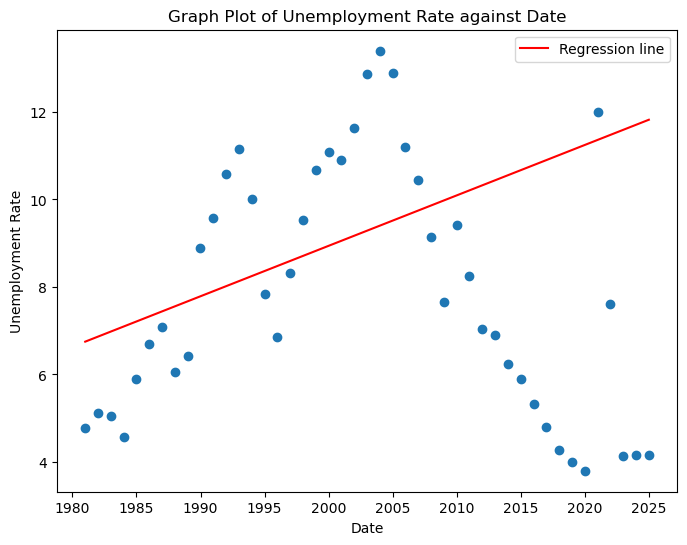

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import quandl
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from scipy import stats


quandl.ApiConfig.api_key = '5qgQ_s6RoVGUwXjRzc9o'

# Data Importation and Preparation

# All of the Data
unemrate_import = quandl.get("ODA/ISR_LUR") # Unemployment rate
unemrate_importdates = list(unemrate_import.index)

# Data from 1980 - 2013
unemrate_data = unemrate_import.loc['1980-12-31':'2013-12-31'] # our training dataset
unemrate_datadates = list(unemrate_data.index) # our date values for training dataset

# Data from 2014-2024
unemrate_test = unemrate_import.loc['2014-12-31':] # our test dataset which we want to predict
unemrate_testdates = list(unemrate_test.index) # our date values for test dataset


# Conversion of date to numbers
unemrate_data.index=unemrate_data.index.map(dt.datetime.toordinal)
unemrate_test.index=unemrate_test.index.map(dt.datetime.toordinal)
unemrate_import.index = unemrate_import.index.map(dt.datetime.toordinal) # converting the whole dataset to ordinal values

# Training dataset
X_train = np.array(list(unemrate_data.index)).reshape(-1,1) # all x values from 1980 to 2013
X_all = np.array(list(unemrate_import.index)).reshape(-1,1) # all the x values
y_train = unemrate_data['Value'].to_numpy().reshape(-1,1) # all y values from 1980 to 2013

# Test dataset
X_test = np.array(list(unemrate_test.index)).reshape(-1,1) # x_test values from 2014 to 2024
y_test = unemrate_test['Value'].to_numpy().reshape(-1,1) # y_test values from 2014 to 2024

# Training our Model
regmodel = LinearRegression().fit(X_train, y_train)

# Predicting for our Test Dataset
y_prediction = regmodel.predict(X_test) # predicition for the X_test values
y_predall = regmodel.predict(X_all) # prediction for all the x values
y_true = unemrate_import.to_numpy() # All the true values
y_predtrain = regmodel.predict(X_train) # Prediction of values from 1980 to 2013 in order to calculate MAPE

# DataFrame showing Actual and Predicted Values from 2014 - 2024
values_dict = {'Actual': y_test.flatten(), 'Predicted': y_prediction.flatten()} 
df = pd.DataFrame(values_dict) # Creating a dataframe to show actual and predicted values
df.index = unemrate_testdates
df.index.name = 'Date'

print(df)
print(f"\nMean Absolute Percentage Error: {mean_absolute_percentage_error(y_train.flatten(), y_predtrain.flatten())*100}%") 


# GRAPH PLOT
plt.figure(figsize=(8,6))
plt.scatter(unemrate_importdates, unemrate_import['Value'].tolist())
plt.plot(unemrate_importdates, y_predall.flatten(), color='r', label='Regression line')
#plt.plot(unemrate_testdates, y_prediction.flatten())
plt.title("Graph Plot of Unemployment Rate against Date")
plt.ylabel("Unemployment Rate")
plt.xlabel("Date")
plt.legend()